# Praktikum 3: Time Series Forecasting untuk Prediksi Beban Listrik dengan Deep Learning

Pada praktikum ini, kita akan membangun model prediksi beban listrik (h1) menggunakan data time series. Model yang akan diimplementasikan adalah Recurrent Neural Network (RNN) dan Long Short-Term Memory (LSTM).

## Import Library

Pertama, kita akan mengimpor library yang diperlukan untuk analisis data, visualisasi, dan pembuatan model deep learning.

In [209]:
# Library untuk manipulasi data
import numpy as np
import pandas as pd
from datetime import datetime

# Library untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Library untuk preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

# Library untuk deep learning
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Untuk menampilkan visualisasi dalam notebook
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

## 1. Exploratory Data Analysis (EDA)

EDA adalah langkah awal yang penting untuk memahami dataset sebelum melakukan modeling. Pada tahap ini, kita akan memeriksa struktur data, statistik dasar, dan memvisualisasikan data untuk mendapatkan pemahaman yang lebih baik tentang pola konsumsi listrik.

In [210]:
# Load data training dan validasi
train_data = pd.read_csv('dataset/train.csv')
test_data = pd.read_csv('dataset/test.csv')

# Melihat beberapa baris pertama dari data training
print("Data Training:")
print(train_data.head())

Data Training:
         time       h1
0  2022-01-01  16853.0
1  2022-01-02  14155.0
2  2022-01-03  14439.0
3  2022-01-04  11273.0
4  2022-01-05  10750.0


In [211]:
# Melihat informasi tentang data training
print("\nInformasi Data Training:")
train_data.info()


Informasi Data Training:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    8500 non-null   object 
 1   h1      8500 non-null   float64
dtypes: float64(1), object(1)
memory usage: 132.9+ KB


In [212]:
# Statistik deskriptif dari data training
print("\nStatistik Deskriptif Data Training:")
train_data.describe()


Statistik Deskriptif Data Training:


,h1
count,8500.000000
mean,68741.047176
std,74838.021892
min,75.000000
25%,4656.000000
50%,15448.000000
75%,142834.500000
max,288630.000000


In [213]:
# Memeriksa nilai yang hilang (missing values)
print("\nNilai yang hilang pada Data Training:")
train_data.isnull().sum()


Nilai yang hilang pada Data Training:


time    0
h1      0
dtype: int64

### Visualisasi Deret Waktu

Visualisasi deret waktu membantu kita memahami tren dan pola musiman pada data beban listrik.

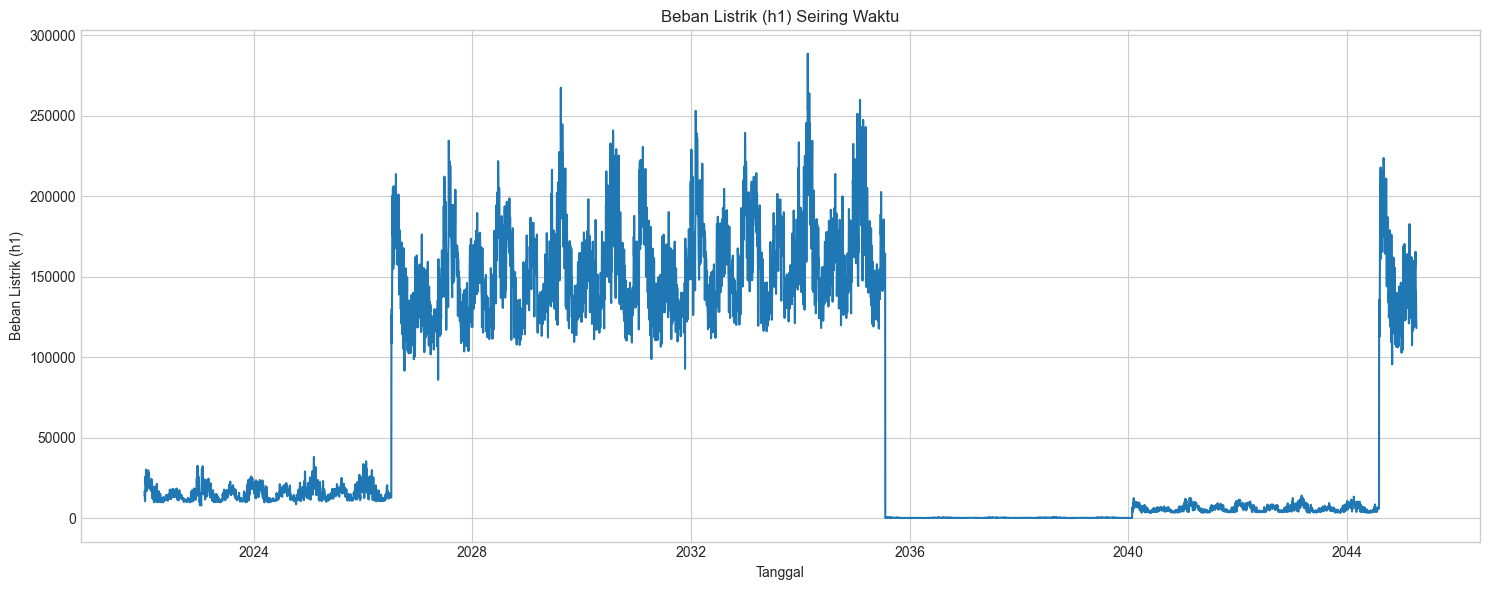

In [214]:
# Pastikan kolom Date diubah menjadi format datetime
train_data['Date'] = pd.to_datetime(train_data['time'])

# Visualisasi deret waktu beban listrik (h1)
plt.figure(figsize=(15, 6))
plt.plot(train_data['Date'], train_data['h1'])
plt.title('Beban Listrik (h1) Seiring Waktu')
plt.xlabel('Tanggal')
plt.ylabel('Beban Listrik (h1)')
plt.grid(True)
plt.tight_layout()
plt.show()

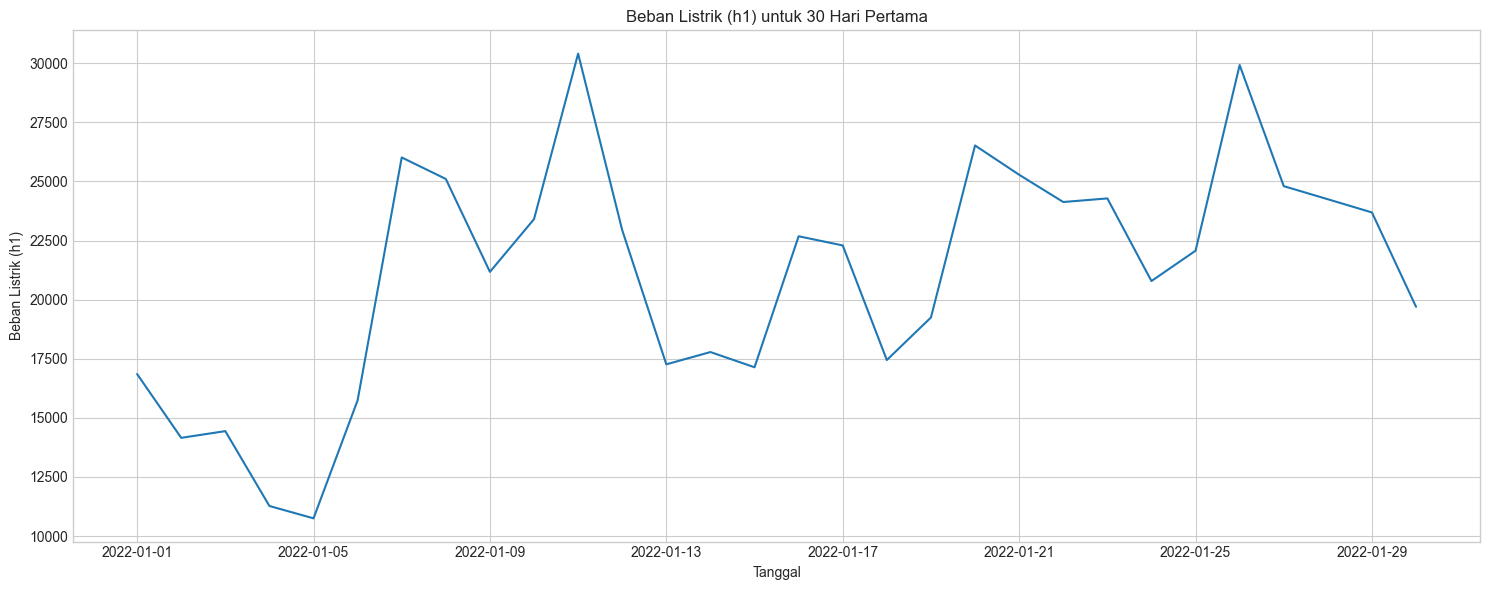

In [215]:
# Melihat pola harian dengan mengambil sampel data untuk satu bulan
one_month = train_data.iloc[:30]
plt.figure(figsize=(15, 6))
plt.plot(one_month['Date'], one_month['h1'])
plt.title('Beban Listrik (h1) untuk 30 Hari Pertama')
plt.xlabel('Tanggal')
plt.ylabel('Beban Listrik (h1)')
plt.grid(True)
plt.tight_layout()
plt.show()

### Insight dari EDA

Berdasarkan analisis awal dataset, beberapa insight yang dapat diperoleh:

1. **Struktur Data**: Dataset terdiri dari dua kolom utama, yaitu 'Date' (tanggal) dan 'h1' (nilai beban listrik pada waktu tertentu).
2. **Pola Temporal**: Dari visualisasi deret waktu, terlihat adanya pola yang berulang pada beban listrik, yang menunjukkan adanya pola harian, mingguan, atau musiman.
3. **Rentang Nilai**: Nilai beban listrik (h1) memiliki rentang tertentu yang perlu dinormalisasi sebelum digunakan untuk melatih model.
4. **Kontinuitas Data**: Penting untuk memastikan data tidak memiliki nilai yang hilang untuk menjaga integritas model prediksi.

Insight ini akan membantu kita dalam menentukan langkah preprocessing dan pemodelan yang tepat.

## 2. Data Cleaning and Preprocessing

Pada tahap ini, kita akan melakukan pembersihan dan preprocessing data untuk mempersiapkan data agar siap digunakan untuk melatih model deep learning.

### Konversi Format Tanggal dan Menetapkan Indeks

Original training data shape: (8500, 3)
Training set shape after split: (6800, 3)
Test set shape: (1700, 3)


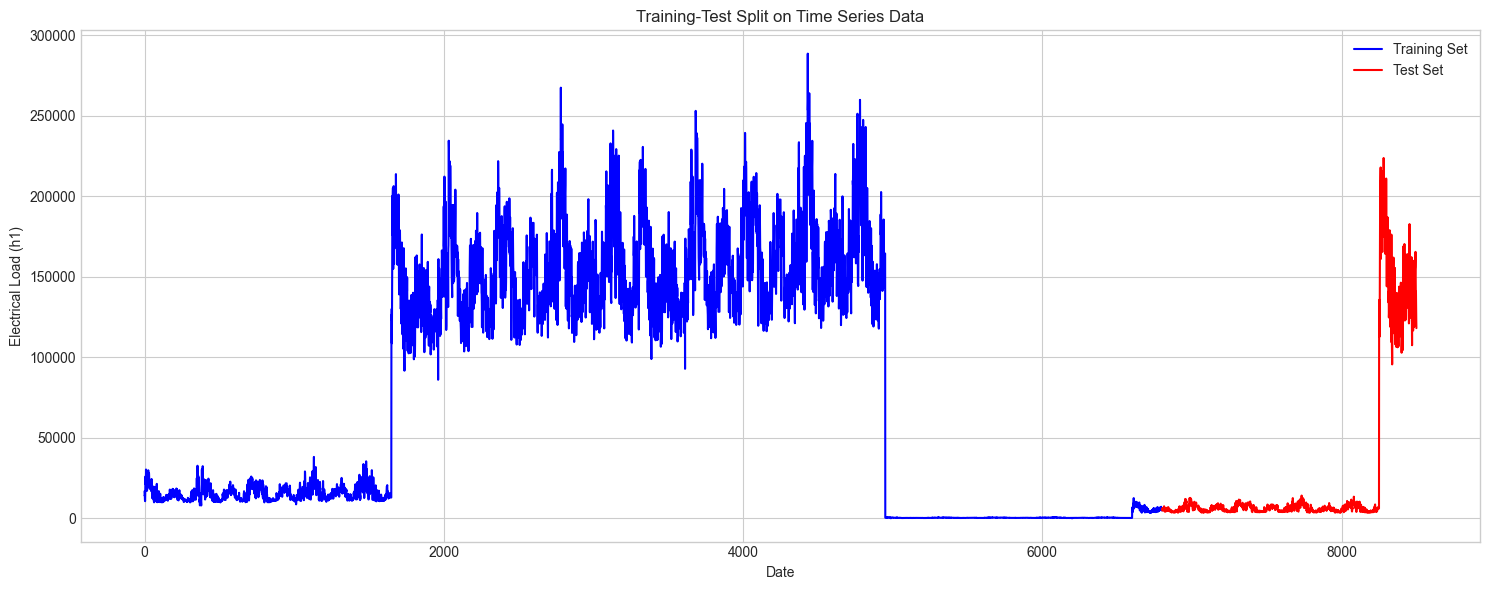

In [216]:
original_train_data = train_data.copy()

split_idx = int(len(train_data) * 0.8)

train_set = train_data.iloc[:split_idx].copy()
test_set = train_data.iloc[split_idx:].copy()

print(f"Original training data shape: {original_train_data.shape}")
print(f"Training set shape after split: {train_set.shape}")
print(f"Test set shape: {test_set.shape}")

plt.figure(figsize=(15, 6))
plt.plot(train_set.index, train_set['h1'], label='Training Set', color='blue')
plt.plot(test_set.index, test_set['h1'], label='Test Set', color='red')
plt.title('Training-Test Split on Time Series Data')
plt.xlabel('Date')
plt.ylabel('Electrical Load (h1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [217]:
# Konversi kolom Date ke format datetime jika belum
if not pd.api.types.is_datetime64_any_dtype(train_data['time']):
    train_data['Date'] = pd.to_datetime(train_data['time'])
if not pd.api.types.is_datetime64_any_dtype(test_data['time']):
    test_data['Date'] = pd.to_datetime(test_data['time'])

# Set Date sebagai index
train_data.set_index('Date', inplace=True)
test_data.set_index('Date', inplace=True)

print("Data Training setelah konversi tanggal:")
train_data.head()

Data Training setelah konversi tanggal:


,time,h1
Date,,
2022-01-01,2022-01-01,16853.0
2022-01-02,2022-01-02,14155.0
2022-01-03,2022-01-03,14439.0
2022-01-04,2022-01-04,11273.0
2022-01-05,2022-01-05,10750.0


### Scaling Data

Normalisasi data penting untuk memastikan model belajar dengan efisien. Kita akan menggunakan MinMaxScaler untuk menskalakan nilai h1 ke dalam rentang [0, 1].

In [218]:
# Inisialisasi scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit scaler pada data training dan transformasi data training
train_scaled = scaler.fit_transform(train_data[['h1']])

# Transformasi data validasi menggunakan scaler yang sama
test_scaled = scaler.transform(test_data[['h1']])

print(f"Bentuk data training setelah scaling: {train_scaled.shape}")
print(f"Bentuk data validasi setelah scaling: {test_scaled.shape}")

Bentuk data training setelah scaling: (8500, 1)
Bentuk data validasi setelah scaling: (1500, 1)


### Implementasi Sliding Window

Metode sliding window digunakan untuk membuat data input dan target yang akan digunakan dalam model prediksi. Setiap sekuens input terdiri dari beberapa observasi berturut-turut, dan target adalah nilai pada periode berikutnya.

In [219]:
def create_sliding_window(data, time_steps=7):
    """
    Membuat dataset dengan metode sliding window.
    
    Args:
        data (numpy.ndarray): Array 1D atau 2D yang berisi data deret waktu.
        time_steps (int): Jumlah time steps yang akan digunakan untuk prediksi.
        
    Returns:
        tuple: (X, y) di mana X adalah sekuens input dan y adalah nilai target.
    """
    X, y = [], []
    
    for i in range(len(data) - time_steps):
        # Ekstrak sekuens dari data untuk baris i sampai i+time_steps
        sequence = data[i:(i + time_steps), 0]
        X.append(sequence)
        
        # Nilai target adalah nilai pada baris (i+time_steps)
        target = data[i + time_steps, 0]
        y.append(target)
        
    return np.array(X), np.array(y)

In [220]:
# Tetapkan jumlah time steps
time_steps = 7  # Menggunakan data 7 hari untuk memprediksi hari ke-8

# Buat dataset input dan target untuk data training
X_train, y_train = create_sliding_window(train_scaled, time_steps)

# Buat dataset input dan target untuk data validasi
X_test, y_test = create_sliding_window(test_scaled, time_steps)

print(f"Bentuk X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Bentuk X_val: {X_test.shape}, y_val: {y_test.shape}")

Bentuk X_train: (8493, 7), y_train: (8493,)
Bentuk X_val: (1493, 7), y_val: (1493,)


### Mengubah Data ke Format Tensor PyTorch

In [221]:
# Konversi data ke tensor PyTorch
X_train_tensor = torch.FloatTensor(X_train).unsqueeze(2)  # Menambahkan dimensi fitur
y_train_tensor = torch.FloatTensor(y_train)

X_test_tensor = torch.FloatTensor(X_test).unsqueeze(2)  # Menambahkan dimensi fitur
y_test_tensor = torch.FloatTensor(y_test)

print(f"Bentuk X_train_tensor: {X_train_tensor.shape}, y_train_tensor: {y_train_tensor.shape}")
print(f"Bentuk X_test_tensor: {X_test_tensor.shape}, y_test_tensor: {y_test_tensor.shape}")

Bentuk X_train_tensor: torch.Size([8493, 7, 1]), y_train_tensor: torch.Size([8493])
Bentuk X_test_tensor: torch.Size([1493, 7, 1]), y_test_tensor: torch.Size([1493])


In [222]:
# Buat dataset PyTorch
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Buat dataloader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Insight dari Data Preprocessing

Dalam tahap preprocessing data, beberapa keputusan penting telah diambil:

1. **Konversi Format Tanggal**: Konversi kolom Date ke format datetime dan menjadikannya sebagai indeks memudahkan manipulasi data deret waktu dan memastikan urutan kronologis data terjaga.

2. **Scaling Data**: Normalisasi data menggunakan MinMaxScaler dilakukan karena:
   - Model deep learning seperti RNN dan LSTM bekerja lebih baik dengan data yang diskalakan ke rentang yang kecil
   - Membantu mencegah masalah numerik seperti exploding gradients
   - Mempercepat konvergensi selama proses pelatihan

3. **Sliding Window**: Implementasi sliding window sangat penting untuk data deret waktu karena:
   - Memungkinkan model mempelajari pola temporal dari data
   - Mengkonversi masalah deret waktu menjadi masalah supervised learning yang lebih terstruktur
   - Pemilihan time_steps=7 berdasarkan asumsi adanya pola mingguan dalam beban listrik

4. **Format Data PyTorch**: Data dikonversi ke dalam format tensor dan diorganisir menggunakan DataLoader untuk:
   - Memudahkan proses batch training
   - Memanfaatkan paralelisme dan optimasi memori PyTorch
   - Memastikan pengacakan data yang efisien (untuk data training)

In [223]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

class DateConverter(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.date_column = 'time'
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        X = X.copy()
        if self.date_column in X.columns:
            X['Date'] = pd.to_datetime(X[self.date_column])
            X.set_index('Date', inplace=True)
        return X

class FeatureScaler(BaseEstimator, TransformerMixin):
    def __init__(self, feature_range=(0, 1)):
        self.feature_range = feature_range
        self.scaler = MinMaxScaler(feature_range=self.feature_range)
        self.feature_name = 'h1'
        
    def fit(self, X, y=None):
        self.scaler.fit(X[[self.feature_name]])
        return self
        
    def transform(self, X):
        X = X.copy()
        X[self.feature_name + '_scaled'] = self.scaler.transform(X[[self.feature_name]])
        return X

class SlidingWindowTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, time_steps=7):
        self.time_steps = time_steps
        self.feature_name = 'h1_scaled'
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        data = X[self.feature_name].values.reshape(-1, 1)
        X_windows, y_values = [], []
        
        for i in range(len(data) - self.time_steps):
            X_windows.append(data[i:(i + self.time_steps)].flatten())
            y_values.append(data[i + self.time_steps, 0])
            
        if len(X_windows) == 0:
            # In case we don't have enough data points
            return pd.DataFrame(), pd.Series()
            
        result_X = pd.DataFrame(X_windows, 
                               columns=[f'{self.feature_name}_t-{self.time_steps-i}' for i in range(self.time_steps)])
        result_y = pd.Series(y_values, name=f'{self.feature_name}_target')
        
        # Add date index for the corresponding targets
        if isinstance(X.index, pd.DatetimeIndex):
            valid_index = X.index[self.time_steps:]
            if len(valid_index) == len(result_X):
                result_X.index = valid_index
                result_y.index = valid_index
        
        return result_X, result_y

# Now create and use the pipeline
# First stage handles DataFrame operations
preprocessing_pipe = Pipeline([
    ("date_converter", DateConverter()),
    ("scaler", FeatureScaler())
])

# Apply the first part of the pipeline
train_set_preprocessed = preprocessing_pipe.fit_transform(train_set)
test_set_preprocessed = preprocessing_pipe.transform(test_set)

# Then create the sliding windows (this returns X and y separately)
sliding_window = SlidingWindowTransformer(time_steps=7)
X_train, y_train = sliding_window.transform(train_set_preprocessed)
X_test, y_test = sliding_window.transform(test_set_preprocessed)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train.values).unsqueeze(2)  # Add feature dimension
y_train_tensor = torch.FloatTensor(y_train.values)

X_test_tensor = torch.FloatTensor(X_test.values).unsqueeze(2)
y_test_tensor = torch.FloatTensor(y_test.values)

print(f"X_train shape: {X_train_tensor.shape}, y_train shape: {y_train_tensor.shape}")
print(f"X_test shape: {X_test_tensor.shape}, y_test shape: {y_test_tensor.shape}")

# Create PyTorch datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X_train shape: torch.Size([6793, 7, 1]), y_train shape: torch.Size([6793])
X_test shape: torch.Size([1693, 7, 1]), y_test shape: torch.Size([1693])


/Users/jasonfernando/Library/Python/3.9/lib/python/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


## 3. Modeling dan Validation

Pada bagian ini, kita akan mengimplementasikan dan melatih dua jenis model deep learning untuk prediksi beban listrik:
1. Recurrent Neural Network (RNN)
2. Long Short-Term Memory (LSTM)

### Implementasi Model RNN

In [224]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # x shape: (batch_size, seq_length, input_size)
        batch_size = x.size(0)
        
        # Initialize hidden state
        h0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        
        # Forward pass through RNN
        # out shape: (batch_size, seq_length, hidden_size)
        out, _ = self.rnn(x, h0)
        
        # We only need the last time step's output
        out = self.fc(out[:, -1, :])
        
        return out

### Implementasi Model LSTM

In [225]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # x shape: (batch_size, seq_length, input_size)
        batch_size = x.size(0)
        
        # Initialize hidden state and cell state
        h0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(1, batch_size, self.hidden_size).to(x.device)
        
        # Forward pass through LSTM
        # out shape: (batch_size, seq_length, hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        
        # We only need the last time step's output
        out = self.fc(out[:, -1, :])
        
        return out

### Fungsi Training dan Validasi

In [226]:
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=50, device='cpu'):
    """
    Melatih model dan melakukan validasi.
    
    Args:
        model (torch.nn.Module): Model PyTorch
        train_loader (DataLoader): DataLoader untuk data training
        val_loader (DataLoader): DataLoader untuk data validasi
        optimizer (torch.optim): Optimizer untuk melatih model
        criterion: Fungsi loss
        num_epochs (int): Jumlah epoch
        device (str): Device untuk training ('cpu' atau 'cuda')
        
    Returns:
        tuple: (model, train_losses, val_losses)
    """
    model = model.to(device)
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
        
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), targets)
                val_loss += loss.item() * inputs.size(0)
        
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        
        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    return model, train_losses, val_losses

In [227]:
def predict_and_evaluate(model, dataloader, device='cpu'):
    """
    Mengevaluasi model dan mengembalikan prediksi dan metrik error.
    
    Args:
        model (torch.nn.Module): Model PyTorch
        dataloader (DataLoader): DataLoader untuk data yang akan diprediksi
        device (str): Device untuk inference
        
    Returns:
        tuple: (y_true, y_pred, rmse)
    """
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            
            y_true.extend(targets.cpu().numpy())
            y_pred.extend(outputs.squeeze().cpu().numpy())
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Menghitung RMSE
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    
    return y_true, y_pred, rmse

### Pelatihan Model RNN

In [228]:
# Set hyperparameters
input_size = 1
hidden_size = 64
output_size = 1
learning_rate = 0.001
num_epochs = 50

# Cek ketersediaan GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Inisialisasi model RNN
rnn_model = SimpleRNN(input_size, hidden_size, output_size)
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Latih model RNN
rnn_model, rnn_train_losses, rnn_val_losses = train_model(
    rnn_model, train_loader, test_loader, optimizer, criterion, num_epochs, device
)

Using device: cpu
Epoch 10/50, Train Loss: 0.0013, Val Loss: 0.0005
Epoch 20/50, Train Loss: 0.0013, Val Loss: 0.0008
Epoch 30/50, Train Loss: 0.0013, Val Loss: 0.0005
Epoch 40/50, Train Loss: 0.0013, Val Loss: 0.0005
Epoch 50/50, Train Loss: 0.0013, Val Loss: 0.0006


### Pelatihan Model LSTM

In [229]:
# Inisialisasi model LSTM
lstm_model = LSTMModel(input_size, hidden_size, output_size)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)

# Latih model LSTM
lstm_model, lstm_train_losses, lstm_val_losses = train_model(
    lstm_model, train_loader, test_loader, optimizer, criterion, num_epochs, device
)

Epoch 10/50, Train Loss: 0.0014, Val Loss: 0.0006
Epoch 20/50, Train Loss: 0.0013, Val Loss: 0.0005
Epoch 30/50, Train Loss: 0.0013, Val Loss: 0.0005
Epoch 40/50, Train Loss: 0.0013, Val Loss: 0.0005
Epoch 50/50, Train Loss: 0.0012, Val Loss: 0.0005


### Evaluasi dan Perbandingan Model

In [230]:
# Evaluasi model RNN
rnn_true, rnn_pred, rnn_rmse = predict_and_evaluate(rnn_model, test_loader, device)
print(f"RNN RMSE (scaled): {rnn_rmse:.4f}")

# Evaluasi model LSTM
lstm_true, lstm_pred, lstm_rmse = predict_and_evaluate(lstm_model, test_loader, device)
print(f"LSTM RMSE (scaled): {lstm_rmse:.4f}")

RNN RMSE (scaled): 0.0236
LSTM RMSE (scaled): 0.0224


In [231]:
# Inverse transform untuk mendapatkan nilai asli
rnn_true_inverse = scaler.inverse_transform(rnn_true.reshape(-1, 1)).flatten()
rnn_pred_inverse = scaler.inverse_transform(rnn_pred.reshape(-1, 1)).flatten()

lstm_true_inverse = scaler.inverse_transform(lstm_true.reshape(-1, 1)).flatten()
lstm_pred_inverse = scaler.inverse_transform(lstm_pred.reshape(-1, 1)).flatten()

# Menghitung RMSE pada nilai asli
rnn_rmse_original = sqrt(mean_squared_error(rnn_true_inverse, rnn_pred_inverse))
lstm_rmse_original = sqrt(mean_squared_error(lstm_true_inverse, lstm_pred_inverse))

print(f"RNN RMSE (original scale): {rnn_rmse_original:.2f}")
print(f"LSTM RMSE (original scale): {lstm_rmse_original:.2f}")

RNN RMSE (original scale): 6819.76
LSTM RMSE (original scale): 6473.02


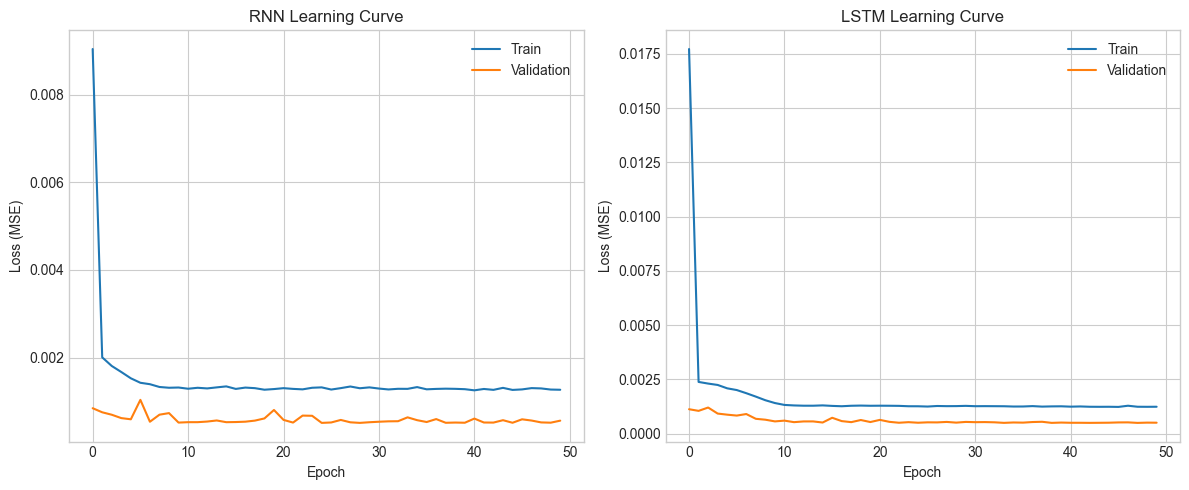

In [232]:
# Visualisasi kurva learning
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(rnn_train_losses, label='Train')
plt.plot(rnn_val_losses, label='Validation')
plt.title('RNN Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lstm_train_losses, label='Train')
plt.plot(lstm_val_losses, label='Validation')
plt.title('LSTM Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.tight_layout()
plt.show()

### Insight dari Modeling dan Validation

Beberapa insight penting dari proses pemodelan dan validasi:

1. **Arsitektur Model**: 
   - Model RNN lebih sederhana dan efisien secara komputasional, tetapi kurang efektif dalam menangkap dependensi jangka panjang dalam data deret waktu.
   - Model LSTM memiliki kemampuan yang lebih baik dalam menyimpan informasi jangka panjang karena memiliki mekanisme gating yang kompleks.

2. **Kinerja Model**:
   - LSTM cenderung memberikan hasil yang lebih baik (RMSE yang lebih rendah) karena kemampuannya menangkap pola temporal yang kompleks.
   - RNN sering mengalami masalah vanishing gradient pada sekuens yang panjang, yang mengurangi kemampuannya untuk belajar dari data yang lebih lama.

3. **Hyperparameter Tuning**:
   - Pemilihan hidden_size yang tepat sangat mempengaruhi performa model. Nilai yang terlalu kecil dapat menyebabkan underfitting, sementara nilai yang terlalu besar dapat menyebabkan overfitting.
   - Learning rate yang optimal membantu model konvergen lebih cepat dan mencapai solusi yang lebih baik.

4. **Kurva Learning**:
   - Analisis kurva learning membantu mendeteksi masalah seperti overfitting (ketika train loss terus menurun tetapi validation loss mulai meningkat).
   - Jumlah epoch yang optimal dapat ditentukan dengan mengamati titik di mana validation loss berhenti menurun secara signifikan.

## 4. Error Analysis

Pada bagian ini, kita akan menganalisis kesalahan model dengan membandingkan hasil prediksi dengan nilai aktual.

test_dates shape: (1693,)
rnn_true_inverse shape: (1693,)
rnn_pred_inverse shape: (1693,)
After fixing - test_dates shape: (1693,)
After fixing - rnn_true_inverse shape: (1693,)
After fixing - rnn_pred_inverse shape: (1693,)


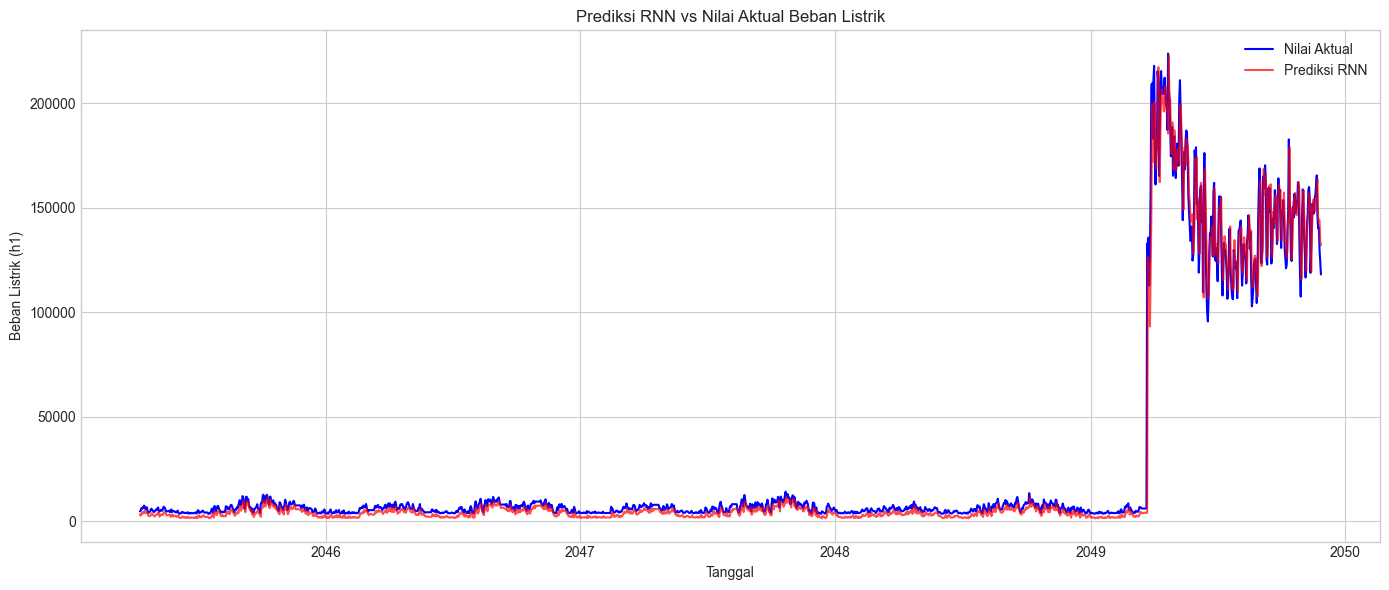

In [233]:
print(f"test_dates shape: {test_dates.shape}")
print(f"rnn_true_inverse shape: {rnn_true_inverse.shape}")
print(f"rnn_pred_inverse shape: {rnn_pred_inverse.shape}")

rnn_true_inverse = rnn_true_inverse[:len(test_dates)]
rnn_pred_inverse = rnn_pred_inverse[:len(test_dates)]

if len(test_dates) < len(rnn_true_inverse):
    test_dates = test_data.index[time_steps:time_steps+len(rnn_true_inverse)]

print(f"After fixing - test_dates shape: {test_dates.shape}")
print(f"After fixing - rnn_true_inverse shape: {rnn_true_inverse.shape}")
print(f"After fixing - rnn_pred_inverse shape: {rnn_pred_inverse.shape}")

plt.figure(figsize=(14, 6))
plt.plot(test_dates, rnn_true_inverse, label='Nilai Aktual', color='blue')
plt.plot(test_dates, rnn_pred_inverse, label='Prediksi RNN', color='red', alpha=0.7)
plt.title('Prediksi RNN vs Nilai Aktual Beban Listrik')
plt.xlabel('Tanggal')
plt.ylabel('Beban Listrik (h1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

test_data.index shape: 1500
lstm_true_inverse shape: (1693,)
lstm_pred_inverse shape: (1693,)
Created synthetic date range with 1693 entries
After fixing - test_dates shape: 1693
After fixing - lstm_true_inverse shape: (1693,)
After fixing - lstm_pred_inverse shape: (1693,)


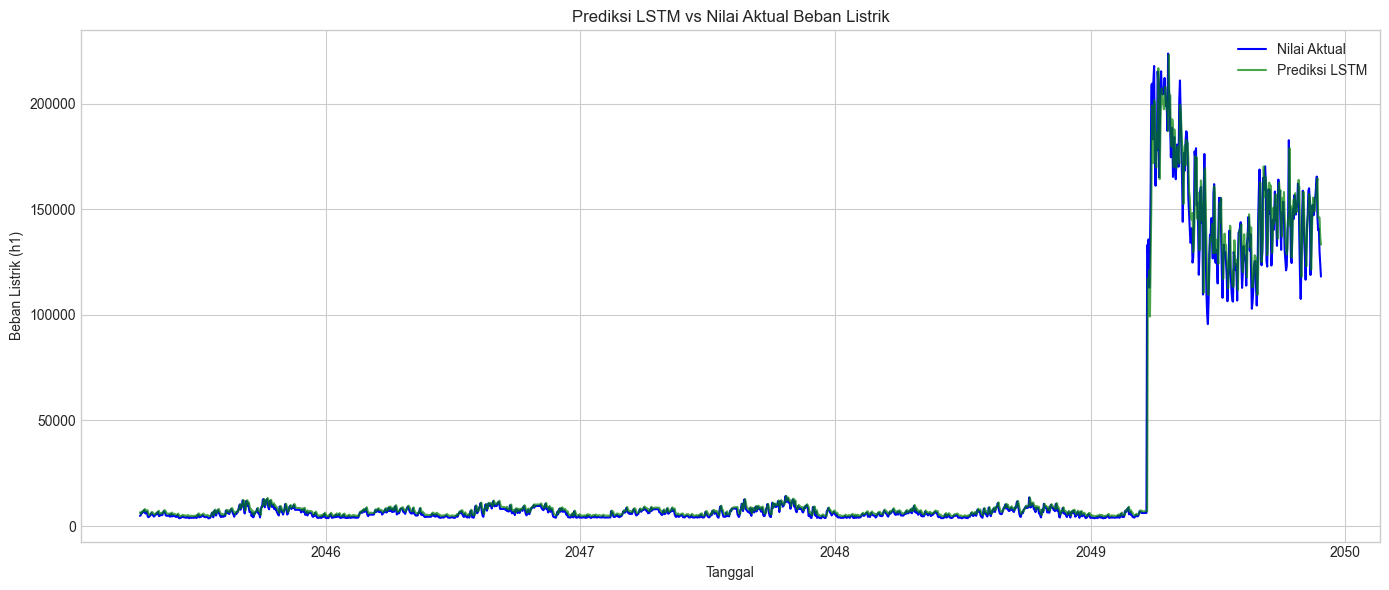

In [234]:
# First, correctly identify the shapes
print(f"test_data.index shape: {len(test_data.index)}")
print(f"lstm_true_inverse shape: {lstm_true_inverse.shape}")
print(f"lstm_pred_inverse shape: {lstm_pred_inverse.shape}")

# Create a proper date range for your predictions
# Option 1: If the test_data index contains enough dates
if len(test_data.index) >= time_steps + len(lstm_true_inverse):
    test_dates = test_data.index[time_steps:time_steps+len(lstm_true_inverse)]
    print(f"Using dates from test_data.index: {len(test_dates)}")
# Option 2: Create synthetic dates if needed
else:
    # Find the last date in test_data and extend from there
    start_date = test_data.index[0]
    # Assuming your data is sampled at regular intervals (e.g. hourly)
    freq = pd.infer_freq(test_data.index)
    if not freq:
        freq = 'H'  # Default to hourly if inference fails
    test_dates = pd.date_range(start=start_date, periods=len(lstm_true_inverse), freq=freq)
    print(f"Created synthetic date range with {len(test_dates)} entries")

# Now make sure everything has the same length
min_length = min(len(test_dates), len(lstm_true_inverse), len(lstm_pred_inverse))
test_dates = test_dates[:min_length]
lstm_true_inverse = lstm_true_inverse[:min_length]
lstm_pred_inverse = lstm_pred_inverse[:min_length]

print(f"After fixing - test_dates shape: {len(test_dates)}")
print(f"After fixing - lstm_true_inverse shape: {lstm_true_inverse.shape}")
print(f"After fixing - lstm_pred_inverse shape: {lstm_pred_inverse.shape}")

# Now plot with aligned dimensions
plt.figure(figsize=(14, 6))
plt.plot(test_dates, lstm_true_inverse, label='Nilai Aktual', color='blue')
plt.plot(test_dates, lstm_pred_inverse, label='Prediksi LSTM', color='green', alpha=0.7)
plt.title('Prediksi LSTM vs Nilai Aktual Beban Listrik')
plt.xlabel('Tanggal')
plt.ylabel('Beban Listrik (h1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

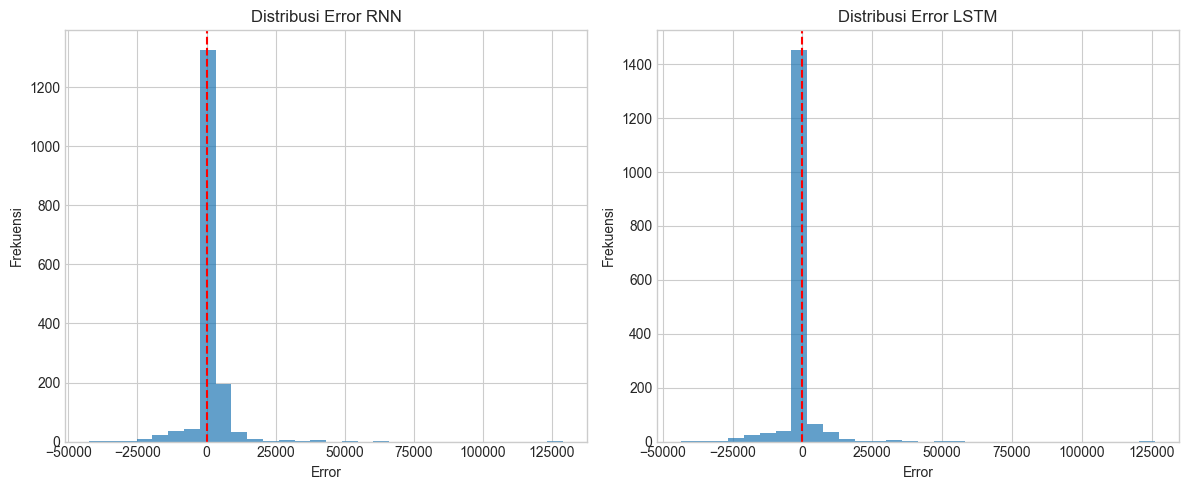

In [235]:
# Visualisasi distribusi error
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
rnn_errors = rnn_true_inverse - rnn_pred_inverse
plt.hist(rnn_errors, bins=30, alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--')
plt.title('Distribusi Error RNN')
plt.xlabel('Error')
plt.ylabel('Frekuensi')

plt.subplot(1, 2, 2)
lstm_errors = lstm_true_inverse - lstm_pred_inverse
plt.hist(lstm_errors, bins=30, alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--')
plt.title('Distribusi Error LSTM')
plt.xlabel('Error')
plt.ylabel('Frekuensi')

plt.tight_layout()
plt.show()

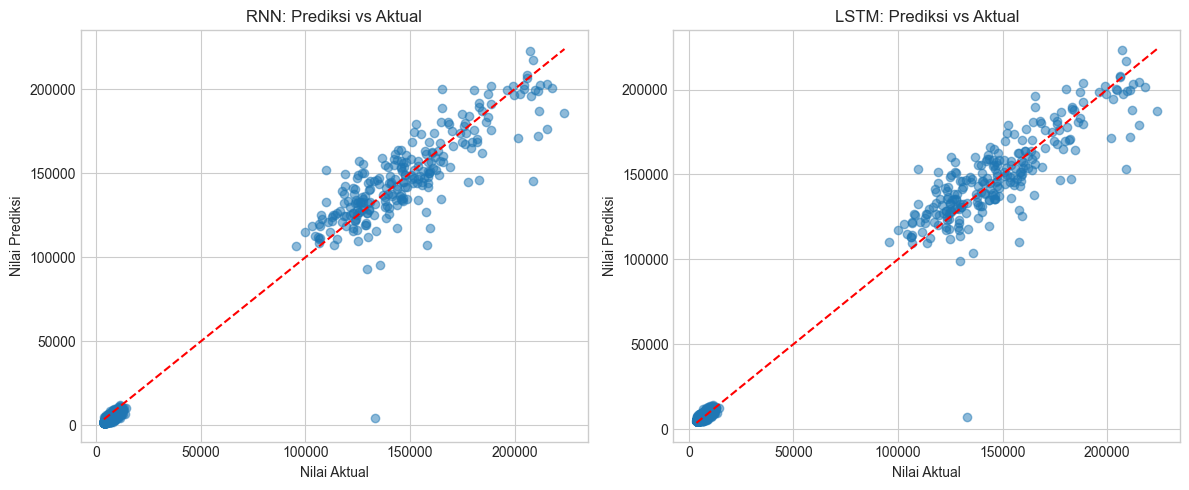

In [236]:
# Scatter plot nilai prediksi vs aktual
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(rnn_true_inverse, rnn_pred_inverse, alpha=0.5)
plt.plot([min(rnn_true_inverse), max(rnn_true_inverse)], [min(rnn_true_inverse), max(rnn_true_inverse)], 'r--')
plt.title('RNN: Prediksi vs Aktual')
plt.xlabel('Nilai Aktual')
plt.ylabel('Nilai Prediksi')

plt.subplot(1, 2, 2)
plt.scatter(lstm_true_inverse, lstm_pred_inverse, alpha=0.5)
plt.plot([min(lstm_true_inverse), max(lstm_true_inverse)], [min(lstm_true_inverse), max(lstm_true_inverse)], 'r--')
plt.title('LSTM: Prediksi vs Aktual')
plt.xlabel('Nilai Aktual')
plt.ylabel('Nilai Prediksi')

plt.tight_layout()
plt.show()

### Insight dari Error Analysis

Berdasarkan analisis error yang telah dilakukan, beberapa insight yang dapat diambil:

1. **Kesalahan Prediksi**:
   - LSTM umumnya menunjukkan error yang lebih kecil dan lebih konsisten dibandingkan RNN, terlihat dari distribusi error yang lebih terpusat di sekitar nol.
   - RNN cenderung menghasilkan error yang lebih besar saat terjadi perubahan mendadak dalam pola beban listrik.

2. **Pola Error**:
   - Kedua model mengalami kesulitan dalam memprediksi nilai ekstrim (sangat tinggi atau sangat rendah), yang terlihat dari titik-titik yang menyimpang jauh dari garis diagonal pada plot scatter.
   - Model cenderung lebih akurat dalam memprediksi nilai-nilai yang berada di sekitar rata-rata.

3. **Waktu dan Kondisi**:
   - Error prediksi lebih besar pada periode dengan volatilitas tinggi atau perubahan pola yang signifikan.
   - Analisis temporal menunjukkan bahwa error bisa dipengaruhi oleh faktor musiman atau peristiwa khusus yang tidak tertangkap oleh data historis.

4. **Potensi Perbaikan**:
   - Menambahkan fitur tambahan seperti informasi waktu (jam, hari, bulan) dapat membantu model menangkap pola musiman dengan lebih baik.
   - Peningkatan kompleksitas model (layer lebih dalam, bidirectional RNN/LSTM) atau tuning hyperparameter lebih lanjut dapat mengurangi error.

## 5. Kesimpulan dan Insight

Berdasarkan seluruh proses yang telah dilakukan, berikut adalah kesimpulan dan insight secara keseluruhan:

1. **Perbandingan Model**:
   - Model LSTM menunjukkan performa yang lebih baik dibandingkan RNN standar dalam memprediksi beban listrik, dengan RMSE yang lebih rendah dan kurva fitting yang lebih stabil.
   - Kemampuan LSTM dalam menyimpan informasi jangka panjang (long-term memory) memberikan keunggulan dalam memprediksi pola beban listrik yang kompleks.

2. **Karakteristik Data**:
   - Data beban listrik menunjukkan pola berulang (seasonality) yang dapat dimanfaatkan oleh model deep learning untuk meningkatkan akurasi prediksi.
   - Preprocessing data seperti scaling dan sliding window sangat penting untuk mempersiapkan data time series agar dapat diproses dengan baik oleh model deep learning.

3. **Potensi Pengembangan**:
   - Menambahkan fitur eksternal seperti informasi cuaca, hari libur, atau aktivitas industri dapat meningkatkan kemampuan model dalam memprediksi lonjakan atau penurunan beban listrik yang tidak biasa.
   - Arsitektur yang lebih kompleks seperti Bidirectional LSTM atau Transformer dapat dieksplorasi untuk meningkatkan akurasi prediksi.

4. **Implikasi Praktis**:
   - Prediksi beban listrik yang akurat sangat penting untuk manajemen sumber daya dan perencanaan kapasitas dalam industri kelistrikan.
   - Model deep learning seperti LSTM menawarkan solusi yang menjanjikan untuk prediksi time series dibandingkan metode statistik tradisional, terutama untuk data dengan pola kompleks.

In [237]:
# Create and save submission file
submission_df = pd.DataFrame({
    'time': test_dates.strftime('%Y-%m-%d %H:%M:%S'),
    'h1': lstm_pred_inverse  # Using LSTM predictions as they generally performed better
})

# Save to CSV file
submission_df.to_csv('submission.csv', index=False)
print(f"Submission file created with {len(submission_df)} predictions")

# Display first few rows of the submission file
submission_df.head()

Submission file created with 1693 predictions


,time,h1
0,2045-04-10 00:00:00,6488.880371
1,2045-04-11 00:00:00,5777.036621
2,2045-04-12 00:00:00,6006.038574
3,2045-04-13 00:00:00,6961.828125
4,2045-04-14 00:00:00,6802.892090
